# The Final Model
- Resample the data (using the technique identified in the MultipleResamplingMethods notebook)
- Run the Decision Tree Model follow by an AdaBoost model
- Examine the results

In [1]:
# Set up the environment
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
%matplotlib inline

# Upload the (cleaned) data

In [2]:
data = pd.read_csv('../data/processed/DecisionTreeDataFinal.csv', index_col=0)
data.sort_index(inplace=True)
data.head()

,OPEID,INSTNM,CITY,NUMBRANCH,PREDDEG,HIGHDEG,CONTROL,region,ADM_RATE,UGDS,...,NetPrice,Cost,PREDDEG_N,Governance,EnrollmentBins,TuitionBins,ExpenditureBins,Complete,RetentionFT,RetentionPT
0,02295000,everest college-phoenix,Phoenix,2,1,3,3,6.0,0.4465,5662.0,...,26004.0,29445.0,Certificate,Private for-profit,xl,highest,high,0.4075,0.43330,0.0000
1,01293700,empire beauty school-paradise valley,Phoenix,1,1,1,3,6.0,NaN,86.0,...,13026.0,34124.0,Certificate,Private for-profit,small,high,highest,0.4800,0.60870,0.2500
2,00886500,empire beauty school-tucson,Tucson,2,1,1,3,6.0,NaN,149.0,...,11915.0,35121.0,Certificate,Private for-profit,small,high,high,0.7025,0.50000,0.7619
3,00107000,thunderbird school of global management,Glendale,1,1,4,2,6.0,NaN,2.0,...,14996.0,19623.0,Certificate,Private nonprofit,small,highest,highest,0.7500,0.74085,NaN
4,01084700,arizona automotive institute,Glendale,1,1,1,3,6.0,NaN,1734.0,...,24082.0,40920.0,Certificate,Private for-profit,large,high,low,0.5725,0.58750,NaN


## Separate the school identity information
This can be merged with the results later, to link model predictions with school names.

In [3]:
identity = data[['OPEID','INSTNM', 'CITY', 'Governance', 'PREDDEG_N']]
identity.shape

(10200, 5)

## Separate the closed schools from the database
Explore the counts and distrubtion of the closed schools, and resample to balance the database.

In [4]:
closed = data.loc[data.CURROPER == False]
closed.shape

(2759, 32)

In [5]:
closed.PREDDEG_N.value_counts()

Certificate       1841
Associates         325
Not classified     253
Bachelor           241
Graduate            99
Name: PREDDEG_N, dtype: int64

In [6]:
closed_degree = closed.pivot_table(index='PREDDEG_N', columns=['CONTROL'], aggfunc='size')
print(closed_degree)

CONTROL           1    2     3
PREDDEG_N                     
Associates       42   26   257
Bachelor         13   94   134
Certificate     117  147  1577
Graduate          1   40    58
Not classified   27   35   191


In [7]:
# Resample the minority class
from sklearn.utils import resample
closed_upsample = resample(closed, replace=True, n_samples=closed.shape[0]*2, random_state=123)

## Separate the currently operating school and filter by year

In [8]:
open_df = data.loc[data.CURROPER==True]
open_df.shape

(7441, 32)

In [9]:
current = open_df.loc[data.Year > 2012]
current.shape

(7441, 32)

In [10]:
current.PREDDEG_N.value_counts()

Certificate       3093
Bachelor          2101
Associates        1488
Not classified     473
Graduate           286
Name: PREDDEG_N, dtype: int64

In [11]:
current_degree = current.pivot_table(index='PREDDEG_N', columns=['CONTROL'], aggfunc='size')
print(current_degree)

CONTROL           1     2     3
PREDDEG_N                      
Associates      780   163   545
Bachelor        588  1241   272
Certificate     594   199  2300
Graduate         15   236    35
Not classified   75    89   309


## Merge the filtered open schools with the upsampled closed schools

In [12]:
data = pd.concat([current, closed_upsample], axis = 0)
data.shape

(12959, 32)

In [13]:
data.CURROPER.value_counts()

True     7441
False    5518
Name: CURROPER, dtype: int64

In [14]:
data.head()

,OPEID,INSTNM,CITY,NUMBRANCH,PREDDEG,HIGHDEG,CONTROL,region,ADM_RATE,UGDS,...,NetPrice,Cost,PREDDEG_N,Governance,EnrollmentBins,TuitionBins,ExpenditureBins,Complete,RetentionFT,RetentionPT
2396,Other,alabama a & m university,Normal,1,3,4,1,5.0,0.8989,4051.0,...,13415.0,18888.0,Bachelor,Public,xl,high,high,0.2914,0.6314,0.5000
2397,Other,university of alabama at birmingham,Birmingham,1,3,4,1,5.0,0.8673,11200.0,...,14805.0,19990.0,Bachelor,Public,xl,high,highest,0.5377,0.8016,0.5000
2398,Other,amridge university,Montgomery,1,3,4,2,5.0,NaN,322.0,...,7455.0,12300.0,Bachelor,Private nonprofit,medium,highest,med,0.6667,0.3750,0.3333
2399,Other,university of alabama in huntsville,Huntsville,1,3,4,1,5.0,0.8062,5525.0,...,17520.0,20306.0,Bachelor,Public,xl,high,high,0.4835,0.8098,0.4444
2400,Other,alabama state university,Montgomery,1,3,4,1,5.0,0.5125,5354.0,...,11936.0,17400.0,Bachelor,Public,xl,high,high,0.2517,0.6219,0.3023


## Basic EDA with the resampled and filtered data

In [15]:
data['PREDDEG_N'].value_counts()

Certificate       6762
Bachelor          2595
Associates        2126
Not classified     979
Graduate           497
Name: PREDDEG_N, dtype: int64

In [16]:
print(data.Governance.value_counts())

Private for-profit    7845
Private nonprofit     2646
Public                2468
Name: Governance, dtype: int64


In [17]:
control_degree = data.pivot_table(index='PREDDEG_N', columns=['CONTROL','CURROPER'], aggfunc='size')
print(control_degree)

CONTROL            1           2           3      
CURROPER       False True  False True  False True 
PREDDEG_N                                         
Associates        88   780    60   163   490   545
Bachelor          21   588   179  1241   294   272
Certificate      247   594   313   199  3109  2300
Graduate           5    15    95   236   111    35
Not classified    55    75    71    89   380   309


## Drop columns not needed for analysis

In [18]:
to_drop = ['OPEID', 'INSTNM', 'CITY', 'HIGHDEG', 'ADM_RATE', 'NetPrice', 'region','EnrollmentBins','Governance',\
           'TuitionBins','ExpenditureBins', 'AVGFACSAL', 'RetentionPT', 'PCTFLOAN', 'Year', 'PREDDEG_N']
df = data.drop(to_drop, axis=1)
df.head()

,NUMBRANCH,PREDDEG,CONTROL,UGDS,CURROPER,TUITFTE,INEXPFTE,PFTFAC,UG25abv,COMP_ORIG_YR4_RT,WDRAW_ORIG_YR4_RT,ENRL_ORIG_YR4_RT,DEBT_MDN,Cost,Complete,RetentionFT
2396,1,3,1,4051.0,True,9063.0,7459.0,0.8856,0.1049,0.292683,0.174806,0.056398,19500.0,18888.0,0.2914,0.6314
2397,1,3,1,11200.0,True,9033.0,17208.0,0.9106,0.2422,0.292683,0.174806,0.056398,16250.0,19990.0,0.5377,0.8016
2398,1,3,2,322.0,True,12057.0,5123.0,0.6721,0.8540,0.383561,0.193277,0.023423,10500.0,12300.0,0.6667,0.3750
2399,1,3,1,5525.0,True,8322.0,9352.0,0.6555,0.2640,0.292683,0.174806,0.056398,16500.0,20306.0,0.4835,0.8098
2400,1,3,1,5354.0,True,7813.0,7393.0,0.6641,0.1270,0.292683,0.174806,0.056398,15854.5,17400.0,0.2517,0.6219


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12959 entries, 2396 to 778
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   NUMBRANCH          12959 non-null  int64  
 1   PREDDEG            12959 non-null  int64  
 2   CONTROL            12959 non-null  int64  
 3   UGDS               12959 non-null  float64
 4   CURROPER           12959 non-null  bool   
 5   TUITFTE            12959 non-null  float64
 6   INEXPFTE           12959 non-null  float64
 7   PFTFAC             12959 non-null  float64
 8   UG25abv            12959 non-null  float64
 9   COMP_ORIG_YR4_RT   12959 non-null  float64
 10  WDRAW_ORIG_YR4_RT  12959 non-null  float64
 11  ENRL_ORIG_YR4_RT   12959 non-null  float64
 12  DEBT_MDN           12959 non-null  float64
 13  Cost               12959 non-null  float64
 14  Complete           12959 non-null  float64
 15  RetentionFT        12959 non-null  float64
dtypes: bool(1), float64(1

In [20]:
df.isnull().sum()

NUMBRANCH            0
PREDDEG              0
CONTROL              0
UGDS                 0
CURROPER             0
TUITFTE              0
INEXPFTE             0
PFTFAC               0
UG25abv              0
COMP_ORIG_YR4_RT     0
WDRAW_ORIG_YR4_RT    0
ENRL_ORIG_YR4_RT     0
DEBT_MDN             0
Cost                 0
Complete             0
RetentionFT          0
dtype: int64

## Split data into training and testing sets.

In [21]:
y = df.CURROPER
X = df.drop('CURROPER', axis=1)

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=21, stratify=y)

In [23]:
X_test.shape

(3888, 15)

# Decision Tree Model

In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier

## Explore the criterion and max_depth hyperparameters

Code modified from https://towardsdatascience.com/decision-tree-build-prune-and-visualize-it-using-python-12ceee9af752

In [25]:
from sklearn import metrics
max_depth = []
acc_gini = []
acc_entropy = []
for i in range(1, 31):
    gtree = DecisionTreeClassifier(criterion='gini', max_depth=i, random_state=21)
    gtree.fit(X_train, y_train)
    gpredict = gtree.predict(X_test)
    acc_gini.append(metrics.accuracy_score(y_test, gpredict))
    ##
    etree = DecisionTreeClassifier(criterion='entropy', max_depth=i, random_state=21)
    etree.fit(X_train, y_train)
    epredict = etree.predict(X_test)
    acc_entropy.append(metrics.accuracy_score(y_test, epredict))
    ##
    max_depth.append(i)

In [26]:
gini_max = max(acc_gini)
gini_idx = acc_gini.index(gini_max)
entropy_max = max(acc_entropy)
entropy_idx = acc_entropy.index(entropy_max)

if gini_max > entropy_max:
    depth = max_depth[gini_idx]
    crit = 'gini'
else:
    depth = max_depth[entropy_idx]
    crit='entropy'
    
print(depth)

23


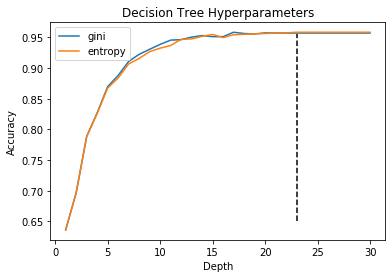

In [27]:
trees = pd.DataFrame({'acc_gini':pd.Series(acc_gini),
                     'acc_entropy':pd.Series(acc_entropy),
                     'max_depth':pd.Series(max_depth)})

plt.plot('max_depth', 'acc_gini', data=trees, label='gini')
plt.plot('max_depth', 'acc_entropy', data=trees, label='entropy')

plt.vlines(depth, 0.65, 0.955, linestyle = '--')
#plt.annotate('Optimal depth', xy = (16, .973))
#plt.annotate('= 13', xy = (16, .97))
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.title('Decision Tree Hyperparameters')
plt.legend()
#plt.show()
plt.savefig('../figures/DTHyperparameters.png')

## Run the Decision Tree model using the identified hyperparameters

In [28]:
# Initialize and fit the model
modelDT = DecisionTreeClassifier(criterion=crit, max_depth=depth, random_state=21)
modelDT.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=23, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=21, splitter='best')

In [29]:
# Use the trained tree to predict the testing data
dt_pred = modelDT.predict(X_test)
dt_pred_prob = modelDT.predict_proba(X_test)

## Model evaluation metrics

In [30]:
print("Model Metrics")
print("Accuracy:", metrics.accuracy_score(y_test, dt_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test, dt_pred))
print('Precision score for "Yes"' , metrics.precision_score(y_test, dt_pred, pos_label = 1))
print('Recall score for "No"' , metrics.recall_score(y_test, dt_pred, pos_label = 0))

Model Metrics
Accuracy: 0.9583333333333334
Balanced accuracy: 0.9607487922705313
Precision score for "Yes" 0.9822926374650512
Recall score for "No" 0.9770531400966184


In [31]:
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_test, dt_pred))

[[1618   38]
 [ 124 2108]]


In [32]:
print(classification_report(y_test, dt_pred))

              precision    recall  f1-score   support

       False       0.93      0.98      0.95      1656
        True       0.98      0.94      0.96      2232

    accuracy                           0.96      3888
   macro avg       0.96      0.96      0.96      3888
weighted avg       0.96      0.96      0.96      3888



In [33]:
importances = modelDT.feature_importances_
indices = np.argsort(importances)[::-1]
names = [X_train.columns[i] for i in indices]

print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, names[f], importances[indices[f]]))

Feature ranking:
1. feature COMP_ORIG_YR4_RT (0.262313)
2. feature ENRL_ORIG_YR4_RT (0.158929)
3. feature UGDS (0.094170)
4. feature CONTROL (0.092008)
5. feature WDRAW_ORIG_YR4_RT (0.082807)
6. feature UG25abv (0.049535)
7. feature NUMBRANCH (0.048663)
8. feature INEXPFTE (0.040186)
9. feature DEBT_MDN (0.034634)
10. feature TUITFTE (0.033859)
11. feature Cost (0.033429)
12. feature RetentionFT (0.022891)
13. feature PFTFAC (0.022162)
14. feature Complete (0.016454)
15. feature PREDDEG (0.007962)


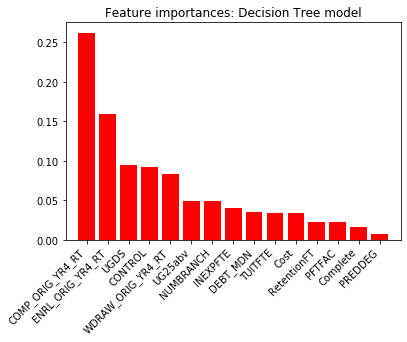

In [34]:
# Plot the impurity-based feature importances of the model
plt.figure()
fig=plt.bar(range(X.shape[1]), importances[indices],
        color="r", align="center")
plt.title("Feature importances: Decision Tree model")
plt.xticks(range(X.shape[1]), names, rotation=45, horizontalalignment='right')
plt.xlim([-1, X.shape[1]])
plt.savefig('../figures/DTFeatureImportance.png',bbox_inches='tight')

Enrollment (UGDS) is the most prominent feature that predicts open schools  (in previous models). Having higher enrollment increases the prediction that a school is currently operating. 

The two most important features in this model are the percentage of students who completed their degree within 4 years at the original institution, and the percentage of students who were still enrolled at the original institution within 4 years.

## Try various thresholds
Though in the inital modeling (CollegeScorecard-Modeling notebook), there was no effect of threshold.

In [35]:
threshold = []
accurate=[]
balance_acc = []
pred_proba = []

for thresh in range(50, 100, 5):
    new_pred = []
    for i in range(0, len(dt_pred_prob)):
        # print(len(dt_pred_prob))
        new_pred.append(dt_pred_prob[i, 1] > (thresh / 100.0))
    # print(new_pred)
    accurate.append(metrics.accuracy_score(y_test, new_pred))
    balance_acc.append(metrics.balanced_accuracy_score(y_test, new_pred))
    threshold.append(thresh)
    pred_proba.append(new_pred)

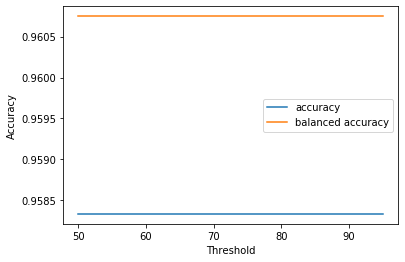

In [36]:
rate = pd.DataFrame({'threshold':pd.Series(threshold),
                     'accuracy':pd.Series(accurate),
                     'balance_acc':pd.Series(balance_acc)})

plt.plot('threshold', 'accuracy', data=rate, label='accuracy')
plt.plot('threshold', 'balance_acc', data=rate, label='balanced accuracy')
#plt.vlines(6, 0.895, 0.915)
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [37]:
print("Balance Accuracy: ", max(balance_acc))
idx = balance_acc.index(max(balance_acc))
print("Threshold: ", threshold[idx])

Balance Accuracy:  0.9607487922705313
Threshold:  50


# AdaBoost model
## Explore the n_estimators hyperparameter

In [38]:
ABmax_depth = []
score_a = []
score_b = []

for i in range(105, 131, 1):
    atree = AdaBoostClassifier(n_estimators=i, random_state=21)
    atree.fit(X_train, y_train)
    apredict = gtree.predict(X_test)
    score_a.append(metrics.accuracy_score(y_test, apredict))
    ##
    btree = AdaBoostClassifier(modelDT, n_estimators=i, random_state=21)
    btree.fit(X_train, y_train)
    bpredict = btree.predict(X_test)
    score_b.append(metrics.accuracy_score(y_test, bpredict))
    ##
    ABmax_depth.append(i)

In [39]:
ideal_estimators = max(score_b)
idx = score_b.index(ideal_estimators)
print(ABmax_depth[idx])

128


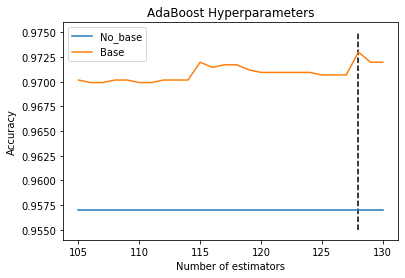

In [40]:
adatrees = pd.DataFrame({'score_a':pd.Series(score_a),
                     'score_b':pd.Series(score_b),
                     'n_estimators':pd.Series(ABmax_depth)})

plt.plot('n_estimators', 'score_a', data=adatrees, label='No_base')
plt.plot('n_estimators', 'score_b', data=adatrees, label='Base')
plt.vlines(ABmax_depth[idx], 0.955, 0.975, linestyle = '--')
plt.xlabel('Number of estimators')
plt.ylabel('Accuracy')
plt.legend()
plt.title('AdaBoost Hyperparameters')
#plt.show()
plt.savefig('../figures/ABHyperparameters.png')

## Run the AdaBoost model using the identified hyperparameter

In [41]:
# Initialize and fit the model
modelAB = AdaBoostClassifier(modelDT, n_estimators=ABmax_depth[idx], random_state=21)
modelAB.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='entropy',
                                                         max_depth=23,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                      

In [42]:
# Use the trained tree to predict the testing data
AB_pred = modelAB.predict(X_test)
AB_pred_prob = modelAB.predict_proba(X_test)

## Model evaluation metrics

In [43]:
print("Model Metrics")
print("Accuracy:", metrics.accuracy_score(y_test, AB_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test, AB_pred))
print('Precision score for "Yes"' , metrics.precision_score(y_test, AB_pred, pos_label = 1))
print('Recall score for "No"' , metrics.recall_score(y_test, AB_pred, pos_label = 0))

Model Metrics
Accuracy: 0.9729938271604939
Balanced accuracy: 0.9736734455352969
Precision score for "Yes" 0.9836289222373806
Recall score for "No" 0.9782608695652174


In [44]:
print(confusion_matrix(y_test, AB_pred))

[[1620   36]
 [  69 2163]]


In [45]:
print(classification_report(y_test, AB_pred))

              precision    recall  f1-score   support

       False       0.96      0.98      0.97      1656
        True       0.98      0.97      0.98      2232

    accuracy                           0.97      3888
   macro avg       0.97      0.97      0.97      3888
weighted avg       0.97      0.97      0.97      3888



In [46]:
importances = modelAB.feature_importances_
std = np.std([tree.feature_importances_ for tree in modelAB.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
names = [X_train.columns[i] for i in indices]

print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, names[f], importances[indices[f]]))

Feature ranking:
1. feature WDRAW_ORIG_YR4_RT (nan)
2. feature UG25abv (nan)
3. feature UGDS (0.121028)
4. feature INEXPFTE (0.090679)
5. feature COMP_ORIG_YR4_RT (0.089959)
6. feature DEBT_MDN (0.084749)
7. feature RetentionFT (0.058268)
8. feature Cost (0.051599)
9. feature TUITFTE (0.047105)
10. feature NUMBRANCH (0.038721)
11. feature PFTFAC (0.027093)
12. feature Complete (0.021742)
13. feature ENRL_ORIG_YR4_RT (0.010337)
14. feature CONTROL (0.002161)
15. feature PREDDEG (0.001458)


/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:578: RuntimeWarning: invalid value encountered in true_divide
  return self.tree_.compute_feature_importances()


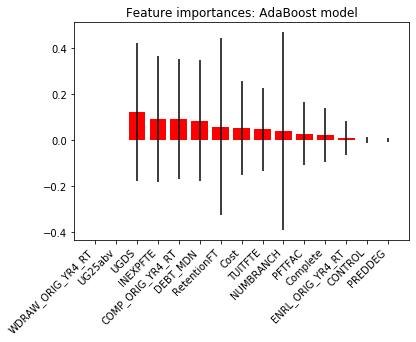

In [47]:
# Plot the feature importances of the model
plt.figure()
plt.title("Feature importances: AdaBoost model")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), names, rotation=45, horizontalalignment='right')
plt.xlim([-1, X.shape[1]])
#plt.show()
plt.savefig('../figures/ABFeatureImportance.png',bbox_inches='tight')

### Try various thresholds for AdaBoost model, too

In [48]:
AB_pred_prob = modelAB.predict_proba(X_test)

ABthreshold = []
ABaccurate=[]
ABbalance_acc = []
ABpred_proba = []

for thresh in range(50, 100, 5):
    new_pred = []
    for i in range(0, len(AB_pred_prob)):
        # print(len(dt_pred_prob))
        new_pred.append(AB_pred_prob[i, 1] > (thresh / 100.0))
    # print(new_pred)
    ABaccurate.append(metrics.accuracy_score(y_test, new_pred))
    ABbalance_acc.append(metrics.balanced_accuracy_score(y_test, new_pred))
    ABthreshold.append(thresh)
    ABpred_proba.append(new_pred)

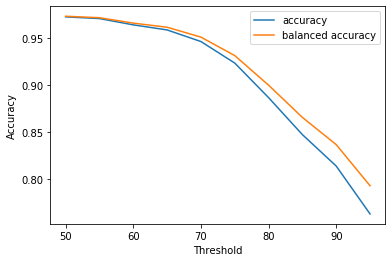

In [49]:
ABrate = pd.DataFrame({'threshold':pd.Series(ABthreshold),
                     'accuracy':pd.Series(ABaccurate),
                     'balance_acc':pd.Series(ABbalance_acc)})

plt.plot('threshold', 'accuracy', data=ABrate, label='accuracy')
plt.plot('threshold', 'balance_acc', data=ABrate, label='balanced accuracy')
#plt.vlines(6, 0.895, 0.915)
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [50]:
print("Balance Accuracy: ", max(ABbalance_acc))
idx = ABbalance_acc.index(max(ABbalance_acc))
print("Threshold: ", ABthreshold[idx])

Balance Accuracy:  0.9736734455352969
Threshold:  50


# Results
We are interested in predicting schools that might be in danger of closing. This would be schools that are currently open, but that the model predicts are closed (a.k.a 'false negatives').

## Put predicted results in a dataframe, and merge with identity data

In [51]:
# Record actual and predicted values for test set.
result_dict = {'CURROPER':y_test, 'Predicted':AB_pred}
results = pd.DataFrame(result_dict)

In [52]:
# Join actual and predicted values for test set to the features used by the model.
predicted = pd.concat([X_test, results], axis=1)
predicted.head()

,NUMBRANCH,PREDDEG,CONTROL,UGDS,TUITFTE,INEXPFTE,PFTFAC,UG25abv,COMP_ORIG_YR4_RT,WDRAW_ORIG_YR4_RT,ENRL_ORIG_YR4_RT,DEBT_MDN,Cost,Complete,RetentionFT,CURROPER,Predicted
9024,31,1,3,550.0,23376.0,6967.0,0.4298,0.5782,0.564626,0.210942,0.000000,12380.5,18947.0,0.3721,0.6475,True,True
4792,1,1,3,270.0,5128.0,6008.0,0.4298,0.5444,0.564626,0.210942,0.000000,4857.0,15973.0,0.5523,0.6552,True,True
5686,1,2,3,557.0,9465.0,3661.0,0.3235,0.5673,0.339112,0.328495,0.010036,9500.0,22907.0,0.2300,0.6129,True,True
309,1,1,3,129.0,7651.0,8874.0,0.4298,0.6688,0.576687,0.239264,0.000000,10885.0,38377.0,0.6124,0.6429,False,False
4898,1,2,1,3381.0,2635.0,5570.0,0.2457,0.2190,0.115119,0.289032,0.037419,5906.0,13481.0,0.3339,0.6095,True,True


In [53]:
# Add a column labeling the results as TP, TN, FP or FN, for ease of access.
predicted['Result'] = np.nan
predicted.loc[(predicted.Predicted==True)&(predicted.CURROPER==True), 'Result'] = 'TP'
predicted.loc[(predicted.Predicted==False)&(predicted.CURROPER==False), 'Result'] = 'TN'
predicted.loc[(predicted.Predicted==True)&(predicted.CURROPER==False), 'Result'] = 'FP'
predicted.loc[(predicted.Predicted==False)&(predicted.CURROPER==True), 'Result'] = 'FN'
print(predicted.Result)

9024    TP
4792    TP
5686    TP
309     TN
4898    TP
        ..
6357    TP
2366    TN
6762    TP
1609    TN
8805    TP
Name: Result, Length: 3888, dtype: object


In [54]:
# Explore schools that are closed, but predicted to be open
false_pos = predicted.loc[(predicted.Predicted == True) & (predicted.CURROPER == False)]
false_pos.shape

(36, 18)

In [55]:
# Explore schools that are currently operating, but predicted to be closed. These are the interesting cases.
false_neg = predicted.loc[(predicted.Predicted==False) & (predicted.CURROPER==True)]
false_neg.shape

(69, 18)

In [56]:
# Merge school name and identity information to the predictions
to_graph = predicted.merge(identity, how='left', left_index=True, right_index=True)
to_graph.head()

,NUMBRANCH,PREDDEG,CONTROL,UGDS,TUITFTE,INEXPFTE,PFTFAC,UG25abv,COMP_ORIG_YR4_RT,WDRAW_ORIG_YR4_RT,...,Complete,RetentionFT,CURROPER,Predicted,Result,OPEID,INSTNM,CITY,Governance,PREDDEG_N
1,1,1,3,86.0,8740.0,10208.0,0.4298,0.3636,0.435897,0.256410,...,0.4800,0.60870,False,False,TN,01293700,empire beauty school-paradise valley,Phoenix,Private for-profit,Certificate
2,2,1,3,149.0,9033.0,7898.0,0.4298,0.1336,0.653959,0.196481,...,0.7025,0.50000,False,False,TN,00886500,empire beauty school-tucson,Tucson,Private for-profit,Certificate
3,1,1,2,2.0,49859.0,33004.0,0.6301,0.5258,0.604934,0.000000,...,0.7500,0.74085,False,False,TN,00107000,thunderbird school of global management,Glendale,Private nonprofit,Certificate
5,1,1,3,252.0,6997.0,3720.0,0.4298,0.4667,0.754839,0.096774,...,0.7534,0.87720,False,False,TN,02561900,brillare hairdressing academy,Scottsdale,Private for-profit,Certificate
13,1,1,3,137.0,3629.0,596.0,0.4298,0.4637,0.753425,0.210942,...,0.8000,0.97620,False,False,TN,02192300,maricopa beauty college llc,Avondale,Private for-profit,Certificate


In [57]:
to_graph.duplicated().sum()

399

In [58]:
to_graph.drop_duplicates(inplace=True)
to_graph.shape

(3489, 23)

In [59]:
to_graph.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3489 entries, 1 to 10199
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   NUMBRANCH          3489 non-null   int64  
 1   PREDDEG            3489 non-null   int64  
 2   CONTROL            3489 non-null   int64  
 3   UGDS               3489 non-null   float64
 4   TUITFTE            3489 non-null   float64
 5   INEXPFTE           3489 non-null   float64
 6   PFTFAC             3489 non-null   float64
 7   UG25abv            3489 non-null   float64
 8   COMP_ORIG_YR4_RT   3489 non-null   float64
 9   WDRAW_ORIG_YR4_RT  3489 non-null   float64
 10  ENRL_ORIG_YR4_RT   3489 non-null   float64
 11  DEBT_MDN           3489 non-null   float64
 12  Cost               3489 non-null   float64
 13  Complete           3489 non-null   float64
 14  RetentionFT        3489 non-null   float64
 15  CURROPER           3489 non-null   bool   
 16  Predicted          3489

## Rerun evaluation metrics
Since the closed schools were resampled before the model was trained, there were duplicated schools in the test set. Once those duplicates are dropped, we can rerun the model metrics to see how well the model performs on the non-duplicated data.

In [60]:
print(confusion_matrix(to_graph['CURROPER'], to_graph['Predicted']))

[[1227   30]
 [  69 2163]]


In [61]:
print(classification_report(to_graph['CURROPER'], to_graph['Predicted']))

              precision    recall  f1-score   support

       False       0.95      0.98      0.96      1257
        True       0.99      0.97      0.98      2232

    accuracy                           0.97      3489
   macro avg       0.97      0.97      0.97      3489
weighted avg       0.97      0.97      0.97      3489



## Explore distribution of schools by predictions and features.

In [62]:
degreeControl = to_graph.pivot_table(index='PREDDEG_N', columns=['Governance','CURROPER'], aggfunc='size')
print(degreeControl)

Governance     Private for-profit        Private nonprofit        Public  \
CURROPER                    False  True              False  True   False   
PREDDEG_N                                                                  
Associates                  114.0  174.0              13.0   56.0   21.0   
Bachelor                     72.0   79.0              43.0  362.0    3.0   
Certificate                 693.0  724.0              71.0   52.0   59.0   
Graduate                     30.0    5.0              20.0   80.0    NaN   
Not classified               82.0   79.0              19.0   34.0   17.0   

Governance             
CURROPER        True   
PREDDEG_N              
Associates      213.0  
Bachelor        169.0  
Certificate     178.0  
Graduate          4.0  
Not classified   23.0  


In [63]:
predControl = to_graph.pivot_table(index='PREDDEG_N', columns=['Governance','Result'], aggfunc='size')
print(predControl)

Governance     Private for-profit                     Private nonprofit       \
Result                         FN    FP     TN     TP                FN   FP   
PREDDEG_N                                                                      
Associates                    7.0   2.0  112.0  167.0               NaN  3.0   
Bachelor                      4.0   1.0   71.0   75.0               2.0  3.0   
Certificate                  38.0  12.0  681.0  686.0               2.0  3.0   
Graduate                      NaN   NaN   30.0    5.0               1.0  NaN   
Not classified                2.0   1.0   81.0   77.0               5.0  NaN   

Governance                  Public                    
Result            TN     TP     FN   FP    TN     TP  
PREDDEG_N                                             
Associates      10.0   56.0    1.0  NaN  21.0  212.0  
Bachelor        40.0  360.0    NaN  2.0   1.0  169.0  
Certificate     68.0   50.0    5.0  2.0  57.0  173.0  
Graduate        20.0   79.0  

In [64]:
controlPivot = to_graph.pivot_table(index='Governance', columns = 'Result', aggfunc='size')
print(controlPivot)

Result              FN  FP   TN    TP
Governance                           
Private for-profit  51  16  975  1010
Private nonprofit   10   9  157   574
Public               8   5   95   579


In [65]:
false_neg = to_graph.loc[to_graph.Result == 'FN']
false_neg.shape

(69, 23)

# Graphically explore the results

## UGDS - Undergraduate enrollment

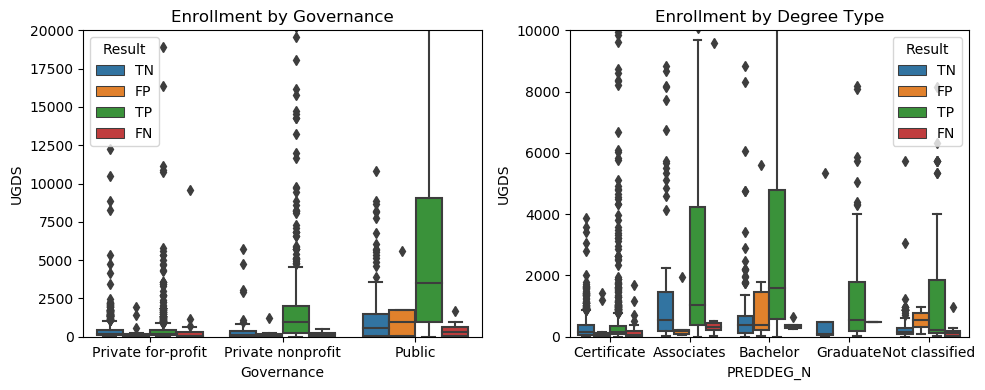

In [66]:
fig=plt.figure(figsize=(10,4), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
sns.boxplot('Governance', 'UGDS', data = to_graph, hue = 'Result')
plt.ylim(0, 20000)
plt.title('Enrollment by Governance')

plt.subplot(1, 2, 2)
sns.boxplot('PREDDEG_N', 'UGDS', data = to_graph, hue = 'Result')
plt.ylim(0, 10000)
plt.title('Enrollment by Degree Type')
plt.tight_layout()

Text(0.5, 0.98, 'Tuition Revenue by Enrollment')

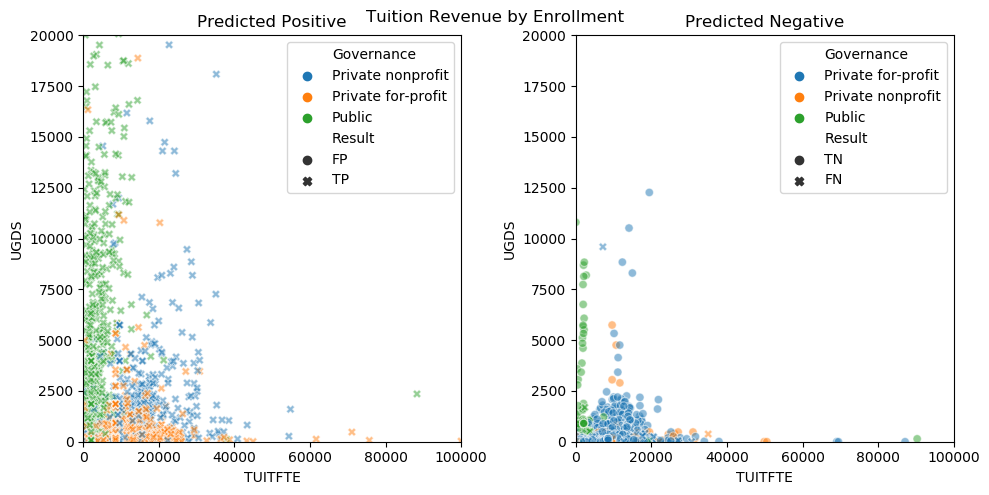

In [67]:
fig=plt.figure(figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
sns.scatterplot('TUITFTE', 'UGDS', data=to_graph.loc[to_graph.Predicted==True], hue = 'Governance',style='Result', alpha=0.5 )
plt.title('Predicted Positive')
plt.xlim(0,100000)
plt.ylim(0,20000)

plt.subplot(1, 2, 2)
sns.scatterplot('TUITFTE', 'UGDS', data=to_graph.loc[to_graph.Predicted==False], hue = 'Governance', style='Result', alpha=0.5)
plt.title('Predicted Negative')
plt.xlim(0,100000)
plt.ylim(0,20000)

plt.tight_layout()
fig.suptitle('Tuition Revenue by Enrollment')
#plt.savefig('../figures/ResultsTuitionEnrollmentControl.png',bbox_inches='tight')

Text(0.5, 0.98, 'Tuition Revenue by Enrollment')

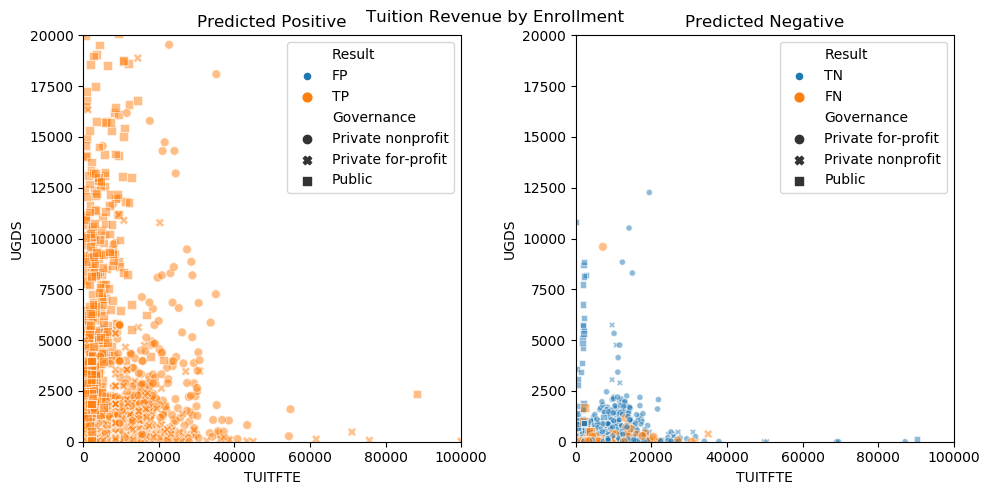

In [68]:
fig=plt.figure(figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
sns.scatterplot('TUITFTE', 'UGDS', data=to_graph.loc[to_graph.Predicted==True], hue='Result',style='Governance', size='Result', sizes={40, 20}, alpha=0.5)
plt.title('Predicted Positive')
plt.xlim(0,100000)
plt.ylim(0,20000)

plt.subplot(1, 2, 2)
sns.scatterplot('TUITFTE', 'UGDS', data=to_graph.loc[to_graph.Predicted==False], hue='Result', style='Governance',size='Result', sizes={20,40}, alpha=0.5)
plt.title('Predicted Negative')
plt.xlim(0,100000)
plt.ylim(0,20000)

plt.tight_layout()
fig.suptitle('Tuition Revenue by Enrollment')
#plt.savefig('../figures/ResultsTuitionEnrollment.png',bbox_inches='tight')

## Tuition revenue and Cost

Text(0.5, 0.98, 'Tuition Revenue by Cost')

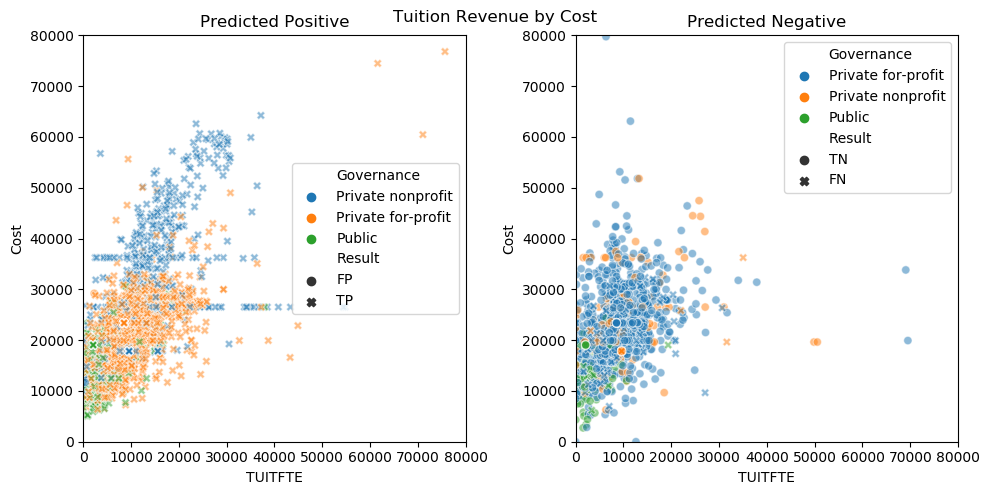

In [69]:
fig=plt.figure(figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
sns.scatterplot('TUITFTE', 'Cost', data=to_graph.loc[to_graph.Predicted==True], hue ='Governance', style='Result', alpha=0.5)
plt.xlim(0, 80000)
plt.ylim(0, 80000)
plt.title('Predicted Positive')

plt.subplot(1, 2, 2)
sns.scatterplot('TUITFTE', 'Cost', data=to_graph.loc[to_graph.Predicted==False], hue = 'Governance', style='Result', alpha=0.5)
plt.xlim(0, 80000)
plt.ylim(0, 80000)
plt.title('Predicted Negative')

plt.tight_layout()
fig.suptitle('Tuition Revenue by Cost')
#plt.savefig('../figures/ResultsTuitionCostControl.png',bbox_inches='tight')

Text(0.5, 0.98, 'Tuition Revenue by Cost')

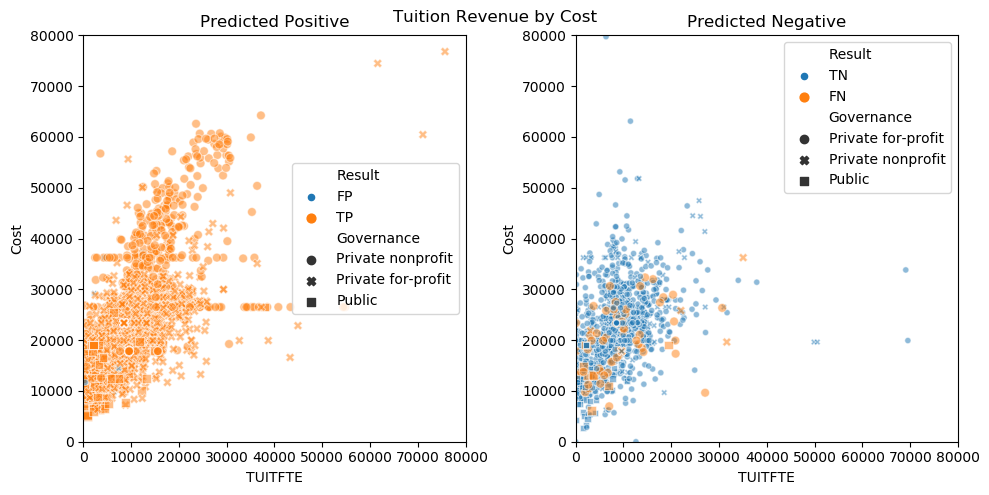

In [70]:
fig=plt.figure(figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
sns.scatterplot('TUITFTE', 'Cost', data=to_graph.loc[to_graph.Predicted==True], hue ='Result', style='Governance', size='Result', sizes={20, 40}, alpha=0.5)
plt.xlim(0, 80000)
plt.ylim(0, 80000)
plt.title('Predicted Positive')

plt.subplot(1, 2, 2)
sns.scatterplot('TUITFTE', 'Cost', data=to_graph.loc[to_graph.Predicted==False], hue = 'Result', style='Governance', size='Result', sizes={20,40}, alpha=0.5)
plt.xlim(0, 80000)
plt.ylim(0, 80000)
plt.title('Predicted Negative')

plt.tight_layout()
fig.suptitle('Tuition Revenue by Cost')
#plt.savefig('../figures/ResultsTuitionCost.png',bbox_inches='tight')

## Cost and Debt

Text(0.5, 0.98, 'Median debt by Cost')

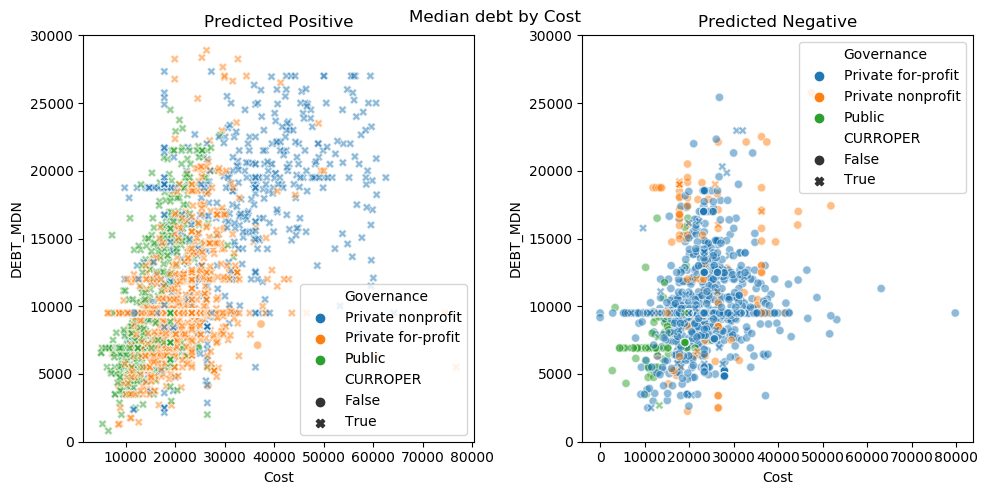

In [71]:
fig=plt.figure(figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
sns.scatterplot('Cost', 'DEBT_MDN', data=to_graph.loc[to_graph.Predicted==True], hue='Governance', style='CURROPER', alpha=0.5)
plt.title('Predicted Positive')
plt.ylim(0,30000)

plt.subplot(1, 2, 2)
sns.scatterplot('Cost', 'DEBT_MDN', data=to_graph.loc[to_graph.Predicted==False], hue='Governance', style='CURROPER', alpha=0.5)
plt.title('Predicted Negative')
plt.ylim(0,30000)

plt.tight_layout()
fig.suptitle('Median debt by Cost')
#plt.savefig('../figures/ResultsCostDebtControl.png',bbox_inches='tight')

Text(0.5, 0.98, 'Median debt by Cost')

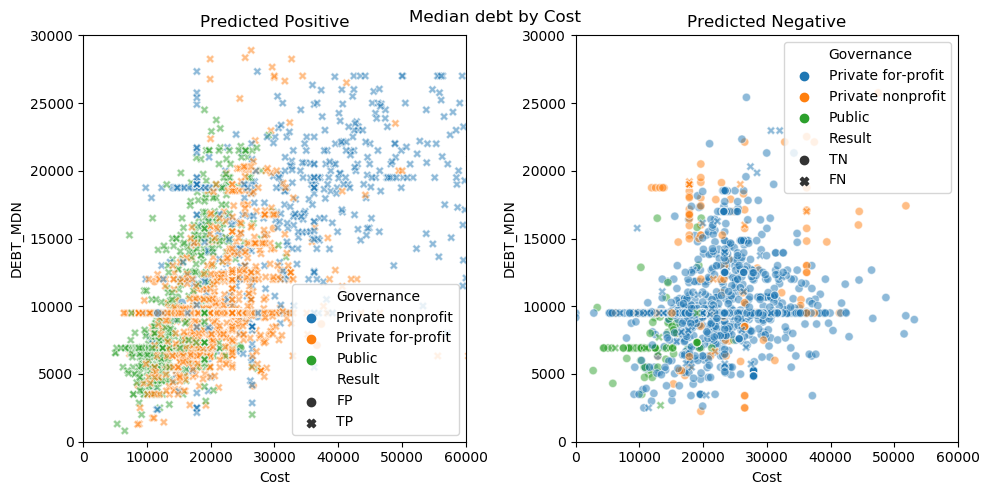

In [72]:
fig=plt.figure(figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
sns.scatterplot('Cost', 'DEBT_MDN', data=to_graph.loc[to_graph.Predicted==True], hue='Governance', style='Result', alpha=0.5)
plt.title('Predicted Positive')
plt.ylim(0,30000)
plt.xlim(0,60000)

plt.subplot(1, 2, 2)
sns.scatterplot('Cost', 'DEBT_MDN', data=to_graph.loc[to_graph.Predicted==False], hue='Governance', style='Result', alpha=0.5)
plt.title('Predicted Negative')
plt.ylim(0,30000)
plt.xlim(0,60000)

plt.tight_layout()
fig.suptitle('Median debt by Cost')
#plt.savefig('../figures/ResultsTuitionCostPositive.png',bbox_inches='tight')

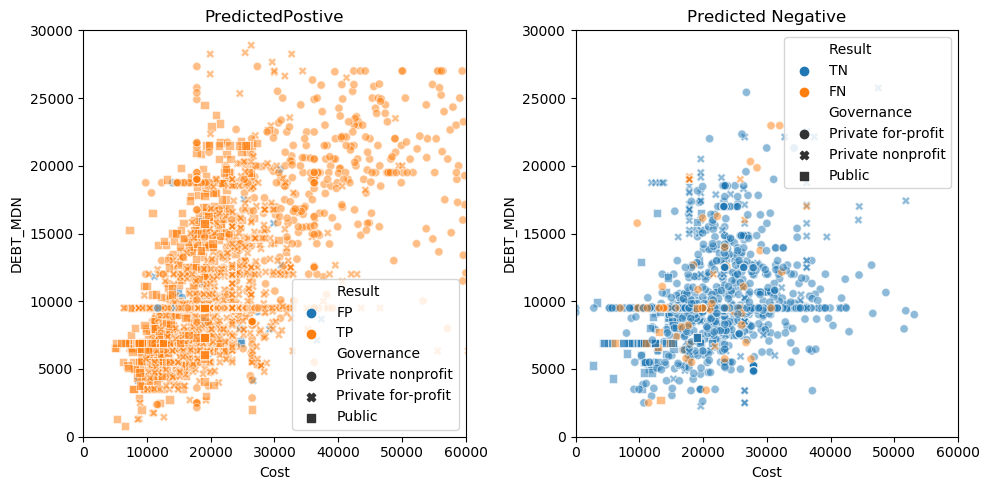

In [73]:
fig=plt.figure(figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 2)
sns.scatterplot('Cost', 'DEBT_MDN', data=to_graph.loc[to_graph.Predicted==False], hue='Result', style='Governance', alpha=0.5)
plt.title('Predicted Negative')
plt.ylim(0,30000)
plt.xlim(0,60000)

plt.subplot(1, 2, 1)
sns.scatterplot('Cost', 'DEBT_MDN', data=to_graph.loc[to_graph.Predicted==True], hue='Result', style='Governance', alpha=0.5)
plt.title('PredictedPostive')
plt.ylim(0,30000)
plt.xlim(0,60000)


plt.tight_layout()
#plt.show()
#plt.savefig('../figures/ResultsTuitionCostNegative.png',bbox_inches='tight')

## Number of Branches

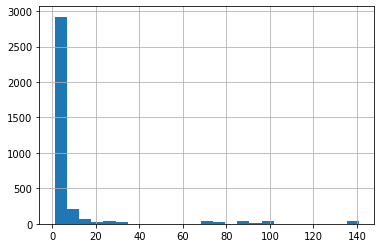

In [74]:
to_graph.NUMBRANCH.hist(bins=25)

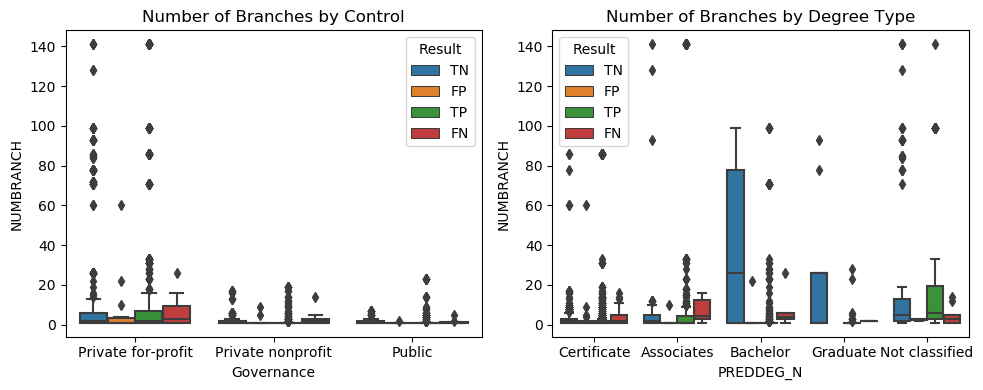

In [75]:
fig=plt.figure(figsize=(10,4), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
sns.boxplot('Governance', 'NUMBRANCH', data = to_graph, hue = 'Result')
plt.title('Number of Branches by Control')

plt.subplot(1, 2, 2)
sns.boxplot('PREDDEG_N', 'NUMBRANCH', data = to_graph, hue = 'Result')
plt.title('Number of Branches by Degree Type')
plt.tight_layout()

Text(0.5, 0.98, 'Number of branches by Enrollment')

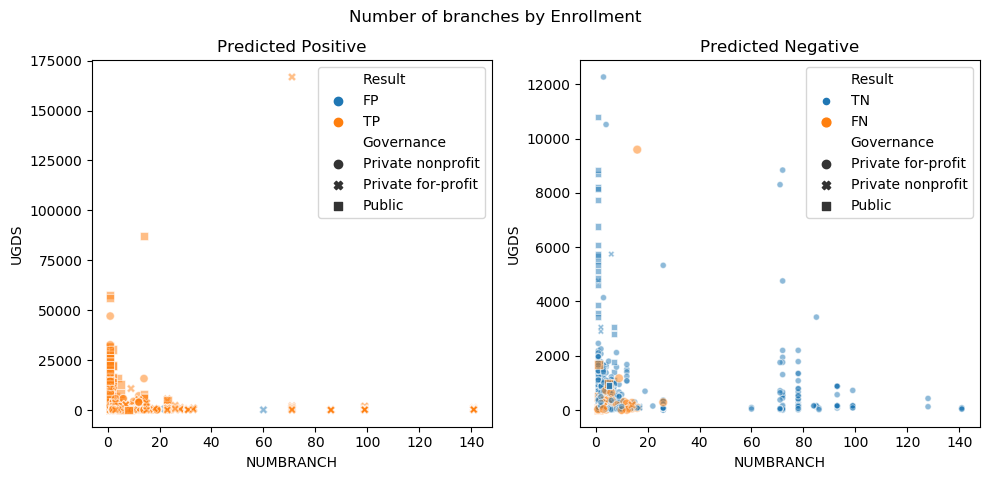

In [76]:
fig=plt.figure(figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
sns.scatterplot('NUMBRANCH', 'UGDS', data=to_graph.loc[to_graph.Predicted==True], hue='Result', style='Governance', alpha=0.5)
plt.title('Predicted Positive')

plt.subplot(1, 2, 2)
sns.scatterplot('NUMBRANCH', 'UGDS', data=to_graph.loc[to_graph.Predicted==False], hue='Result', style='Governance',size='Result', sizes={20,40}, alpha=0.5)
plt.title('Predicted Negative')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle('Number of branches by Enrollment')

## Instructional Expenditure

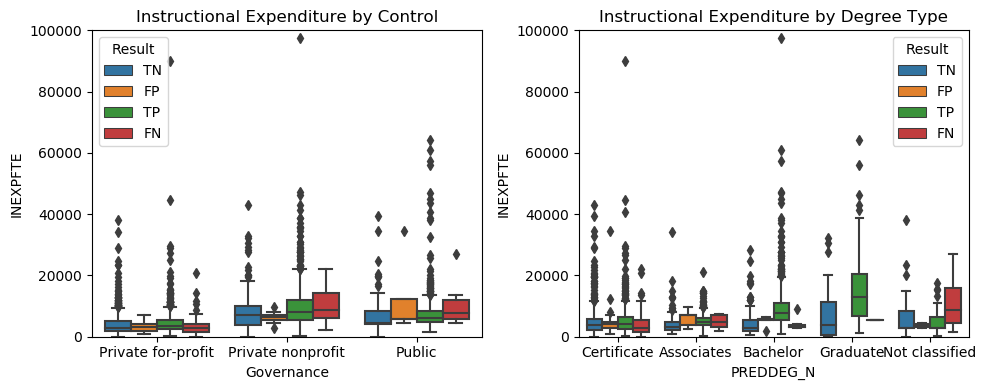

In [77]:
fig=plt.figure(figsize=(10,4), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
sns.boxplot('Governance', 'INEXPFTE', data = to_graph, hue = 'Result')
plt.ylim(0, 100000)
plt.title('Instructional Expenditure by Control')

plt.subplot(1, 2, 2)
sns.boxplot('PREDDEG_N', 'INEXPFTE', data = to_graph, hue = 'Result')
plt.ylim(0, 100000)
plt.title('Instructional Expenditure by Degree Type')
plt.tight_layout()

Text(0.5, 0.98, 'Expenditure by Enrollment')

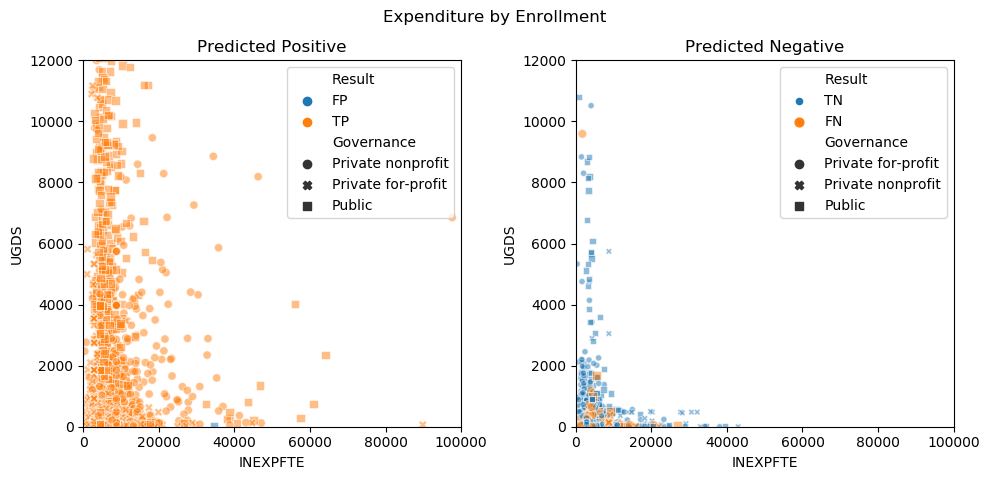

In [78]:
fig=plt.figure(figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
#sns.scatterplot('', 'UGDS', data=to_graph, hue = 'Result')
sns.scatterplot('INEXPFTE', 'UGDS', data=to_graph.loc[to_graph.Predicted==True], hue='Result', style='Governance', alpha=0.5)
plt.xlim(0, 100000)
plt.ylim(0, 12000)
plt.title('Predicted Positive')

plt.subplot(1, 2, 2)
#sns.scatterplot('INEXPFTE', 'UGDS', data=to_graph.loc[to_graph.Result=='FN'], hue = 'CONTROL')
sns.scatterplot('INEXPFTE', 'UGDS', data=to_graph.loc[to_graph.Predicted==False], hue='Result', style='Governance',size='Result', sizes={20,40}, alpha=0.5)
plt.xlim(0, 100000)
plt.ylim(0, 12000)
plt.title('Predicted Negative')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle('Expenditure by Enrollment')
#plt.savefig('../figures/ResultsExpenditureUGDS.png',bbox_inches='tight')

Text(0.5, 0.98, 'Expenditure by Cost')

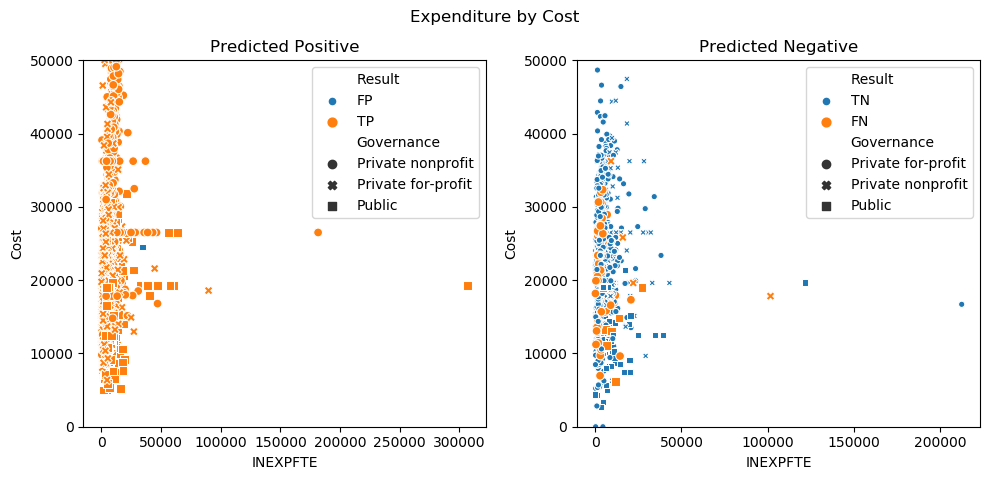

In [79]:
fig=plt.figure(figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
sns.scatterplot('INEXPFTE', 'Cost', data=to_graph.loc[to_graph.Predicted==True], hue='Result', style='Governance',size='Result', sizes={20,40})#, alpha=0.5)
plt.ylim(0, 50000)
plt.title('Predicted Positive')

plt.subplot(1, 2, 2)
sns.scatterplot('INEXPFTE', 'Cost', data=to_graph.loc[to_graph.Predicted==False], hue = 'Result', style='Governance', size='Result', sizes={20,40})
plt.ylim(0, 50000)
plt.title('Predicted Negative')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle('Expenditure by Cost')
#plt.savefig('../figures/ResultsExpenditureCostPositive.png',bbox_inches='tight')

## Graphs of 4yr bachelors institutions

In [80]:
bach = to_graph.loc[to_graph['PREDDEG_N']=='Bachelor']
bach = bach.copy()
bach.shape

(728, 23)

Text(0.5, 0.98, "Bachelor's - Cost by Debt")

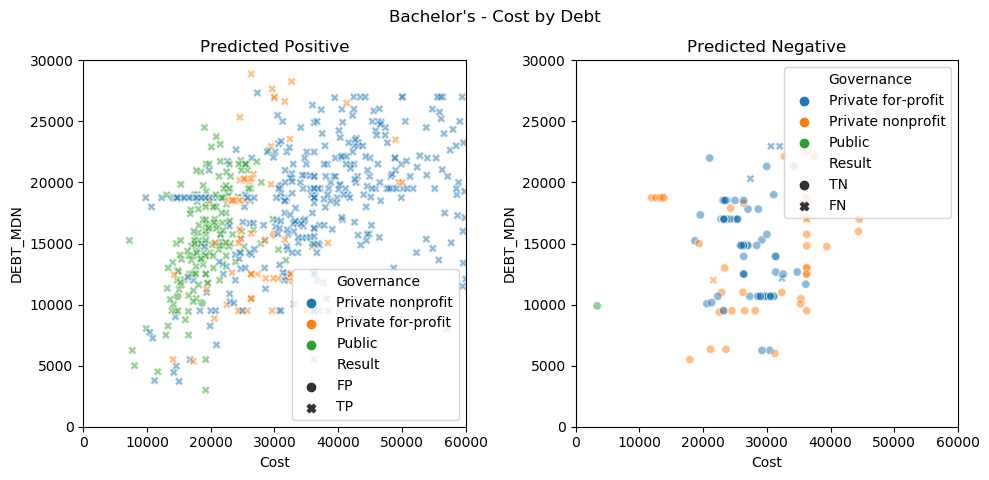

In [81]:
fig=plt.figure(figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
sns.scatterplot('Cost', 'DEBT_MDN', data=bach.loc[bach.Predicted==True], hue='Governance', style='Result', alpha=0.5)
plt.title('Predicted Positive')
plt.ylim(0,30000)
plt.xlim(0,60000)

plt.subplot(1, 2, 2)
sns.scatterplot('Cost', 'DEBT_MDN', data=bach[bach.Predicted==False], hue='Governance', style='Result', alpha=0.5)
plt.title('Predicted Negative')
plt.ylim(0,30000)
plt.xlim(0,60000)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("Bachelor's - Cost by Debt")
#plt.savefig('../figures/ResultsBachTuitionCostNegative.png',bbox_inches='tight')

Text(0.5, 0.98, "Bachelor's - Cost by Debt")

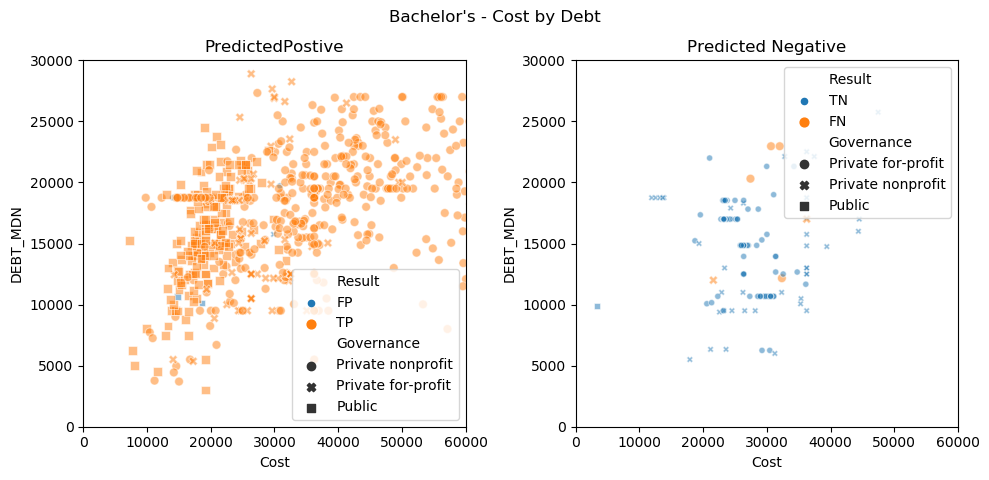

In [82]:
fig=plt.figure(figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
sns.scatterplot('Cost', 'DEBT_MDN', data=bach.loc[bach.Predicted==True], hue='Result', style='Governance',size='Result', sizes={20,40}, alpha=0.5)
plt.title('PredictedPostive')
plt.ylim(0,30000)
plt.xlim(0,60000)

plt.subplot(1, 2, 2)
sns.scatterplot('Cost', 'DEBT_MDN', data=bach.loc[bach.Predicted==False], hue='Result', style='Governance', size='Result', sizes={20,40}, alpha=0.5)
plt.title('Predicted Negative')
plt.ylim(0,30000)
plt.xlim(0,60000)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("Bachelor's - Cost by Debt")
#plt.savefig('../figures/ResultsBachTuitionCostPositive.png',bbox_inches='tight')

Text(0.5, 0.98, "Bachelor's - Tuition Revenue by Cost")

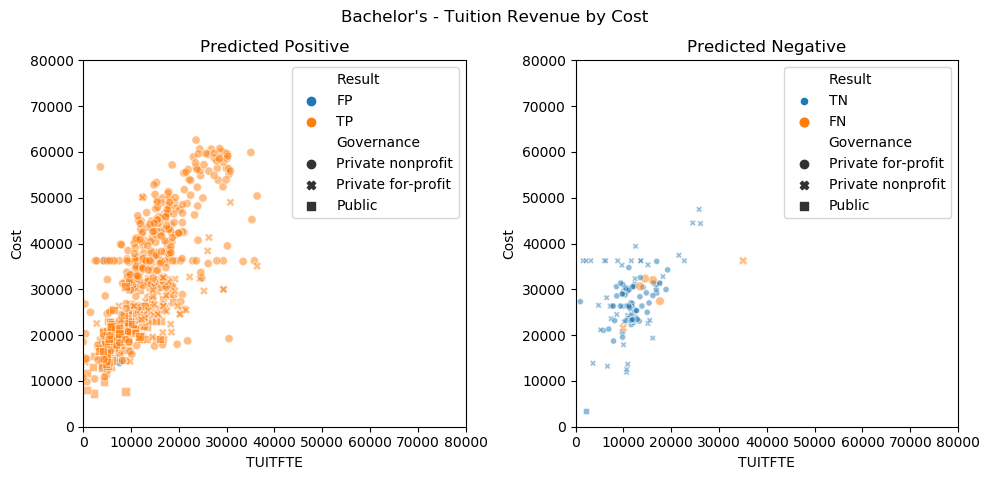

In [83]:
fig=plt.figure(figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
sns.scatterplot('TUITFTE', 'Cost', data=bach.loc[bach.Predicted==True], hue ='Result', style='Governance', alpha=0.5)
plt.xlim(0, 80000)
plt.ylim(0, 80000)
plt.title('Predicted Positive')

plt.subplot(1, 2, 2)
sns.scatterplot('TUITFTE', 'Cost', data=bach.loc[bach.Predicted==False], hue = 'Result', style='Governance',size='Result', sizes={20,40}, alpha=0.5)
plt.xlim(0, 80000)
plt.ylim(0, 80000)
plt.title('Predicted Negative')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("Bachelor's - Tuition Revenue by Cost")
#plt.savefig('../figures/ResultsBachTuitionCost.png',bbox_inches='tight')

Text(0.5, 0.98, "Bachelor's - Tuition Revenue by Enrollment")

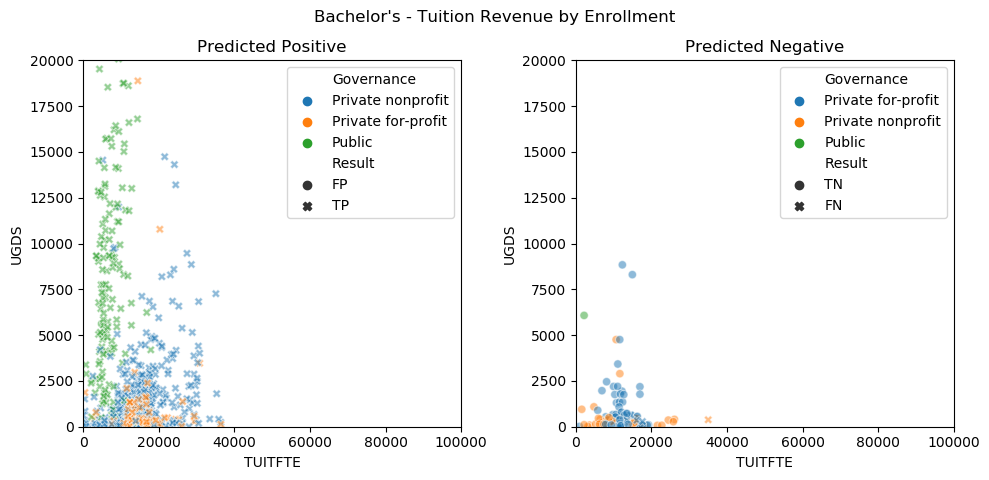

In [84]:
fig=plt.figure(figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
sns.scatterplot('TUITFTE', 'UGDS', data=bach.loc[bach.Predicted==True], hue = 'Governance',style='Result', alpha=0.5 )
plt.title('Predicted Positive')
plt.xlim(0,100000)
plt.ylim(0,20000)

plt.subplot(1, 2, 2)
sns.scatterplot('TUITFTE', 'UGDS', data=bach.loc[bach.Predicted==False], hue = 'Governance', style='Result', alpha=0.5)
plt.title('Predicted Negative')
plt.xlim(0,100000)
plt.ylim(0,20000)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("Bachelor's - Tuition Revenue by Enrollment")
#plt.savefig('../figures/ResultsBachTuitionEnrollmentControl.png',bbox_inches='tight')

## Explore predictions of various schools
I know there are several private colleges whose name starts with 'Bethel', that are members of the potential client's organization. I'm going to explore the predictions made for schools with similar names, as a proxy for the client's member institutions.

In [85]:
bethel = data.loc[data['INSTNM'].str.startswith('bethel')]
bethel = bethel.copy()
bethel.head()

,OPEID,INSTNM,CITY,NUMBRANCH,PREDDEG,HIGHDEG,CONTROL,region,ADM_RATE,UGDS,...,NetPrice,Cost,PREDDEG_N,Governance,EnrollmentBins,TuitionBins,ExpenditureBins,Complete,RetentionFT,RetentionPT
3582,Other,bethel college-indiana,Mishawaka,1,3,4,2,3.0,0.7158,1579.0,...,17730.0,33617.0,Bachelor,Private nonprofit,large,highest,high,0.6466,0.8407,0.5714
3746,Other,bethel college-north newton,North Newton,1,3,3,2,4.0,0.6440,482.0,...,18539.0,33781.0,Bachelor,Private nonprofit,medium,highest,high,0.5278,0.7030,NaN
4298,Other,bethel university,Saint Paul,4,3,4,2,4.0,0.9485,3178.0,...,24845.0,42692.0,Bachelor,Private nonprofit,xl,highest,high,0.7136,0.8504,0.0000
4299,Other,bethel seminary-st paul,Saint Paul,4,4,4,2,4.0,NaN,3178.0,...,24506.5,26508.0,Graduate,Private nonprofit,NaN,highest,high,0.5290,0.9271,NaN
5978,Other,bethel university,McKenzie,1,3,4,2,5.0,0.5103,5063.0,...,17459.0,26864.0,Bachelor,Private nonprofit,xl,high,high,0.3020,0.5556,0.0882


In [86]:
bethel.CURROPER.value_counts()

False    8
True     7
Name: CURROPER, dtype: int64

In [87]:
## Run the Bethel schools through the model and see what it predicts
to_drop = ['OPEID', 'INSTNM', 'CITY', 'HIGHDEG', 'ADM_RATE', 'NetPrice', 'region','EnrollmentBins','Governance',\
           'TuitionBins','ExpenditureBins', 'AVGFACSAL', 'RetentionPT', 'PCTFLOAN', 'Year', 'PREDDEG_N']
bethel_test = bethel.drop(to_drop, axis=1)

In [88]:
bethel_test = bethel_test.drop('CURROPER', axis=1)
bethel_pred = modelAB.predict(bethel_test)

In [89]:
bethel['Predict'] = bethel_pred
print(bethel[['INSTNM','CITY', 'CURROPER', 'Predict']].head(15))

                           INSTNM          CITY  CURROPER  Predict
3582       bethel college-indiana     Mishawaka      True     True
3746  bethel college-north newton  North Newton      True     True
4298            bethel university    Saint Paul      True     True
4299      bethel seminary-st paul    Saint Paul      True     True
5978            bethel university      McKenzie      True     True
6835    bethel seminary-san diego     San Diego      True     True
8986               bethel college       Hampton      True     True
1953  bethel seminary of the east      Landover     False    False
1228  bethel seminary of the east  Willow Grove     False    False
350   bethel seminary of the east  Willow Grove     False    False
1953  bethel seminary of the east      Landover     False    False
350   bethel seminary of the east  Willow Grove     False    False
1228  bethel seminary of the east  Willow Grove     False    False
350   bethel seminary of the east  Willow Grove     False    F

## Explore the private nonprofit, bachelor's granting institutions from the test set.

In [90]:
dangerBachPrivate = bach.loc[(bach['CONTROL']==2) & (bach['Result']=='FN')]
dangerBachPrivate.shape

(2, 23)

In [91]:
dangerBachPrivate[['INSTNM', 'CITY', 'Governance', 'PREDDEG_N']]

,INSTNM,CITY,Governance,PREDDEG_N
4973,davis college,Johnson City,Private nonprofit,Bachelor
8711,ottawa university-online,Ottawa,Private nonprofit,Bachelor


### Notes on false negative, private nonprofit, bachelor's granting institutions
An initial version of the model predicted 7 nonprofit bachelor's granting institutions would be closed. However, they all had current, updated websites, which I took as a sign that they are currently operating.
- Naropa Univerisity still in operation
- Thomas More College of Liberal Arts is still in operation
- Williamson Christian College is still in operation
- Ecclesia College is still open
- Messenger College is still open
- LIU = Long Island University - Brentwood is still open, Riverhead is still open

### Notes on false negatives
- Davis College (Johnson City) - still operating
- Ottawa University-online (Ottawa) - appears to be operating, though I need more information to pinpoint which Ottowa Univeristy it is.